In [182]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mip import Model, xsum, maximize, BINARY

In [183]:
def mip_entropy_constrained(Lambda):
    Omega = 1
    p = Omega * all_dijs + Lambda * all_prb0s
    w = A_eq
    c = 1
    I = range(np.shape(w)[1])

    m = Model('knapsack')

    x = [m.add_var(var_type=BINARY) for i in I]

    m.objective = maximize(xsum(p[i] * x[i] for i in I))

    for j in range (0,cells_num):
        m += xsum(w[j][i] * x[i] for i in I) == c

    opt_value = m.optimize()

    # print('\n', mip_pairs_show)
    selected = [i for i in I if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))

    mip_pairs = []
    for i in I:
        mip_pair = x[i].x
        mip_pairs = np.append(mip_pairs, mip_pair)

    k = 0
    mip_xx = np.zeros([cells_num, cells_num])
    for i in range(0,cells_num):
        for j in range(i+1,cells_num):
            mip_xx[i,j] = mip_pairs[k]
            k +=1

    mip_pairs_show = np.array(np.where(mip_xx == 1))

    obj_value_db = 10*np.log10(m.objective_value)
    
    mip_dijs = mip_pairs * all_dijs
    mip_distortion = sum(mip_dijs)
    mip_db = 10 * np.log10(mip_distortion)

    mip_prb0s = mip_pairs * all_prb0s
    mip_prb0 = sum(mip_prb0s)
    if mip_prb0 == 0 or mip_prb0 == 1:
        mip_entropy = 0
    else:
        mip_entropy = -mip_prb0 * np.log2(mip_prb0)-(1-mip_prb0)*np.log2(1-mip_prb0)

    # print(opt_distortion)
    print('\n1_DE(dB)_lam'+str(Lambda),mip_db)
    print('1_H(S0)_lam'+str(Lambda), mip_entropy)

In [184]:
img_file = 'lena_gray_512.tif'
intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
imf = np.float32(intensities)

#http://www.robertstocker.co.uk/jpeg/jpeg_new_10.htm
fqtable = np.array([[2,1,1,1,1,1,1,1],
                    [1,1,2,2,2,2,2,4],
                    [3,2,2,2,2,5,4,4],
                    [3,4,6,5,6,6,6,5],
                    [6,6,6,7,9,8,6,7],
                    [9,7,6,6,8,11,8,9],
                    [10,10,10,10,10,6,8,11],
                    [12,11,10,12,9,10,10,10]])

qtable = np.array([[16,11,10,16,24, 40, 51, 61],
                   [12,12,14,19,26, 58, 60, 55],
                   [14,13,16,24,40, 57, 69, 56],
                   [14,17,22,29,51, 87, 80, 62],
                   [18,22,37,56,68, 109,103,77],
                   [24,36,55,64,81, 104,113,92],
                   [49,64,78,87,103,121,120,101],
                   [72,92,95,98,112,100,103,99]])

all_nq_ac = []
all_fq_ac = []
for i in range(0,64):
    for j in range(0,64):
        blk = imf[8*i:8*(i+1), 8*j:8*(j+1)]
        dct = cv2.dct(blk)
        nq_coef = np.round(dct)
        nq_coef_ac = np.delete(nq_coef, [0,0])
        all_nq_ac = np.append(all_nq_ac, nq_coef_ac)
        
        fq_coef = np.round(dct/fqtable)
        fq_coef_ac = np.delete(fq_coef, [0,0])
        all_fq_ac = np.append(all_fq_ac, fq_coef_ac)

nq_u, nq_counts = np.unique(all_nq_ac, return_counts=True)
fq_u, fq_counts = np.unique(all_fq_ac, return_counts=True)

In [185]:
fq_u_255_raw = np.delete(fq_u, np.argwhere((fq_u > 255) | (fq_u < -255)))
fq_counts_255_raw = np.delete(fq_counts, np.argwhere((fq_u > 255) | (fq_u < -255)))
fq_u_255_1 = np.array(range(-255,256))
fq_u_255 = np.delete(fq_u_255_1, np.argwhere(fq_u_255_1 == 0))

fq_counts_255 = np.zeros(510)
for i in range(-255,0):
    if i in fq_u_255_raw:
        fq_counts_255[i+255] =  fq_counts_255_raw[np.argwhere(fq_u_255_raw == i)]
for i in range(1,256):
    if i in fq_u_255_raw:
        fq_counts_255[i+254] =  fq_counts_255_raw[np.argwhere(fq_u_255_raw == i)]

In [281]:
size  = 8
cells_num = 2**size

a0 = -2**size + 1
a1 = -2**(size-1)
a2 =  2**(size-1)
a3 =  2**(size)-1

a_set1 = np.array(range(a0, a1+1))
a_set2 = np.array(range(a2, a3+1))
a_set = np.append(a_set1, a_set2)

fq_counts_cat = np.zeros(cells_num)
for i in a_set1:
    if i in fq_u_255_raw:
        fq_counts_cat[i+(cells_num-1)] =  fq_counts_255_raw[np.argwhere(fq_u_255_raw == i)]
        
for i in a_set2:
    if i in fq_u_255_raw:
        fq_counts_cat[i] =  fq_counts_255_raw[np.argwhere(fq_u_255_raw == i)]
        
var = a_set
sum_counts = sum(fq_counts_cat)
prbs = fq_counts_cat/sum_counts

In [282]:
nb_all_yijs = []
nb_all_dijs = []
enb_all_prb0s = []

for i in range(0,int(cells_num/2)):
    j = int(cells_num/2 + i)
#     print(i,j)

    '''Choose the strategy'''
# # Strategy1    
#     nb_yij = (var[i]*prbs[i]+var[j]*prbs[j])/(prbs[i]+prbs[j])
    

# # Strategy2
# #     nb_yij = (var[i]+var[j])/2 # Strategy2
# #     nb_all_yijs = np.append(nb_all_yijs, nb_yij) # Strategy2
    
#     nb_dij\# Strategy1 and 2
#         = var[i]**2*prbs[i] + nb_yij**2*prbs[i] - nb_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + nb_yij**2*prbs[j] - nb_yij*2*var[j]*prbs[j] 

# Strategy3
    nb_dij = 0.5*(\
      var[i]**2*prbs[i] + var[i]**2*prbs[i] - var[i]*2*var[i]*prbs[i]\
    + var[j]**2*prbs[j] + var[i]**2*prbs[j] - var[i]*2*var[j]*prbs[j]\
    + var[i]**2*prbs[i] + var[j]**2*prbs[i] - var[j]*2*var[i]*prbs[i]\
    + var[j]**2*prbs[j] + var[j]**2*prbs[j] - var[j]*2*var[j]*prbs[j]) 

    nb_all_dijs = np.append(nb_all_dijs, nb_dij)
    
    
    
    enb_prb0 = max(prbs[j],prbs[i])
    enb_all_prb0s = np.append(enb_all_prb0s, enb_prb0)
    
sum_enb_prb0 = sum(enb_all_prb0s)
if sum_enb_prb0 == 0 or sum_enb_prb0 == 1:
    enb_entropy = 0
else:
    enb_entropy = -sum_enb_prb0 * np.log2(sum_enb_prb0)-(1-sum_enb_prb0)*np.log2(1-sum_enb_prb0)
    
    
    
nb_distortion = np.sum(nb_all_dijs)
nb_db = 10 * np.log10(nb_distortion)

nb_prb0s = prbs[0: int(cells_num/2)]  
nb_prb0 = sum(nb_prb0s)
nb_entropy = -nb_prb0*np.log2(nb_prb0)-(1-nb_prb0)*np.log2(1-nb_prb0)

# print('\n',nb_distortion)
print('\nnb_DE(dB)',nb_db)
print('nb_H(S0)',nb_entropy)

print('enb_H(S0) ',enb_entropy)




nb_DE(dB) 48.65367552273264
nb_H(S0) 0.999998596842659
enb_H(S0)  0.7557114550839916


In [283]:
fb_all_yijs = []
fb_all_dijs = []
efb_all_prb0s = []

for i in range(0,int(cells_num/2)):
    j = int(cells_num -(i+1))
#     print(i,j)

    '''Choose the strategy'''
# # Strategy1    
#     fb_yij = (var[i]*prbs[i]+var[j]*prbs[j])/(prbs[i]+prbs[j])
    

# Strategy2
#     nb_yij = (var[i]+var[j])/2 # Strategy2
#     nb_all_yijs = np.append(nb_all_yijs, nb_yij) # Strategy2


# # Strategy1 and 2
#     fb_dij\
#         = var[i]**2*prbs[i] + fb_yij**2*prbs[i] - fb_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + fb_yij**2*prbs[j] - fb_yij*2*var[j]*prbs[j] 

# # Strategy3
#     nb_dij = 0.5*(\
#       var[i]**2*prbs[i] + var[i]**2*prbs[i] - var[i]*2*var[i]*prbs[i]\
#     + var[j]**2*prbs[j] + var[i]**2*prbs[j] - var[i]*2*var[j]*prbs[j]\
#     + var[i]**2*prbs[i] + var[j]**2*prbs[i] - var[j]*2*var[i]*prbs[i]\
#     + var[j]**2*prbs[j] + var[j]**2*prbs[j] - var[j]*2*var[j]*prbs[j]) 


    fb_all_dijs = np.append(fb_all_dijs, fb_dij)
    
    
    
    efb_prb0 = max(prbs[j],prbs[i])
    efb_all_prb0s = np.append(efb_all_prb0s, efb_prb0)
       
    
    
    
sum_efb_prb0 = sum(efb_all_prb0s)
if sum_efb_prb0 == 0 or sum_efb_prb0 == 1:
    efb_entropy = 0
else:
    efb_entropy = -sum_efb_prb0 * np.log2(sum_efb_prb0)-(1-sum_efb_prb0)*np.log2(1-sum_efb_prb0)
    

    
fb_distortion = np.sum(fb_all_dijs)
fb_db = 10 * np.log10(fb_distortion)

fb_prb0s = prbs[0: int(cells_num/2)]  
fb_prb0 = sum(fb_prb0s)
fb_entropy = -fb_prb0*np.log2(fb_prb0)-(1-fb_prb0)*np.log2(1-fb_prb0)

# print('\n',nb_distortion)
print('\nfb_DE(dB)',fb_db)
print('fb_H(S0)',fb_entropy)

print('efb_H(S0) ',efb_entropy)


fb_DE(dB) 46.24473245371054
fb_H(S0) 0.999998596842659
efb_H(S0)  0.9328791795388165


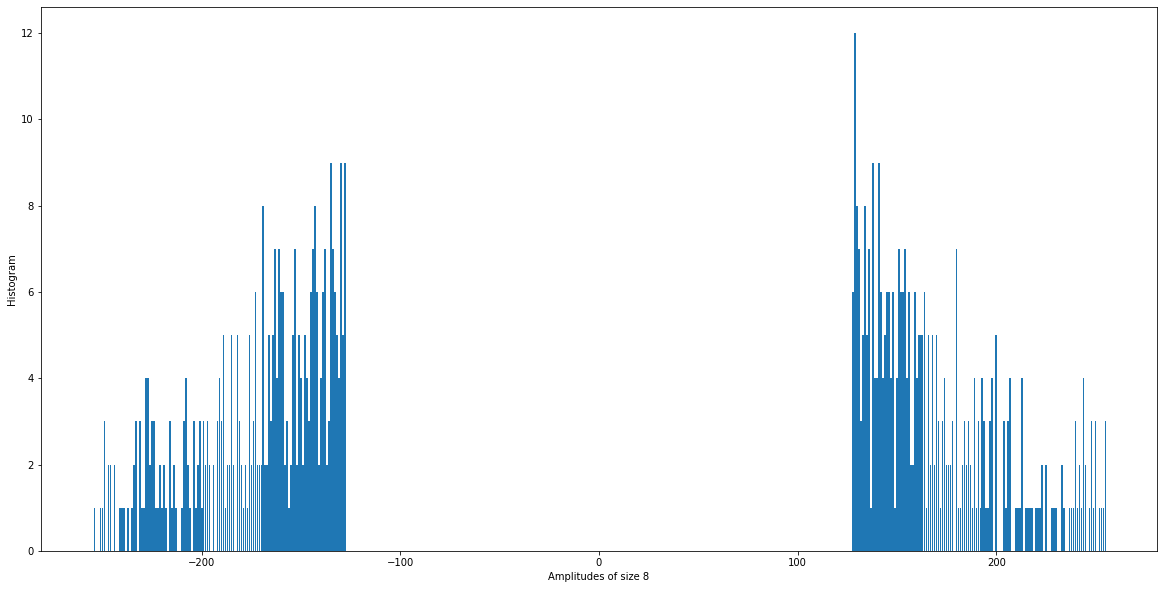

In [180]:
plt.figure(figsize=(20,10))
plt.bar(var,fq_counts_cat)
# plt.xticks(var)
plt.xlabel('Amplitudes of size '+str(size))
plt.ylabel('Histogram')
plt.savefig('histogram of size '+ str(size))


In [103]:
# MIP #######################################################################
all_yijs = []
all_dijs = []
all_prb0s = []
for i in range(0,cells_num-1):
    for j in range(i+1,cells_num):
        
        '''Choose the strategy'''
# Strategy1: Eve knows the source statistics which is rare in image encrytion
        possible_yij = (var[i]*prbs[i]+var[j]*prbs[j])/(prbs[i]+prbs[j])

# # # Strategy2: Eve knows the reconstruction value of each cell
# #         possible_yij = (var[i]+var[j])/2
# #         #possibel_yij = random.choice([var[i],var[j]])


        
        all_yijs = np.append(all_yijs, possible_yij)
        
#         possible_dij\
#         = var[i]**2*prbs[i] + possible_yij**2*prbs[i] - possible_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + possible_yij**2*prbs[j] - possible_yij*2*var[j]*prbs[j]
        
# # Strategy3
#         yi = var[i]
#         yj = var[j]
#         possible_dij = 0.5*(
#           var[i]**2*prbs[i] + yi**2*prbs[i] - yi*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + yi**2*prbs[j] - yi*2*var[j]*prbs[j]\
#         + var[i]**2*prbs[i] + yj**2*prbs[i] - yj*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + yj**2*prbs[j] - yj*2*var[j]*prbs[j])
        
        
               
        all_dijs = np.append(all_dijs, possible_dij)
                
        possible_prb0 = max(prbs[j],prbs[i])
        all_prb0s = np.append(all_prb0s, possible_prb0)

######### ######### ######### ######### ######### ######### ######### #########
'''For distortion and entropy, we must implement the integer linear programming.'''
'''Linear programming does not results in binary values'''

all_length = int(cells_num * (cells_num-1) / 2)

A_eq = np.zeros([cells_num, all_length])
k = 0
for i in range(0, cells_num-1):
    for j in range(i+1,cells_num):
        A_eq[i,k]=1
        k+=1
k = 0
for j in range(1, cells_num):
    for i in range (j,cells_num):
        A_eq[i,k]=1
        k+=1

b_eq = np.ones([cells_num,])

/home/mehr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [104]:
'''Do not run this cell, it takes time'''
#MIP 1
results_all_lambdas = []
# for Lambda in [0, 1000, 1000000]:
for Lambda in [0]:
    
    results = mip_entropy_constrained(Lambda)



1_DE(dB)_lam0 -4.472791903511613
1_H(S0)_lam0 0.8811203453197273
